In [1]:
import Pkg; Pkg.add(["Plots", "Interact"]);

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/srv/rep/22-course-cse6643/mybinder/Project.toml`
  No Changes to `~/srv/rep/22-course-cse6643/mybinder/Manifest.toml`


In [2]:
const STATIC_LECTURE = false;

In [3]:
function draw(plt)
    if STATIC_LECTURE
        filename = Base.Filesystem.tempname() * ".png"
        savefig(filename)
        return display("image/png", read(filename))
    else
        return plt
    end
end

draw (generic function with 1 method)

In [4]:
using LinearAlgebra;
using Plots; default(l=2, size=(900,550), label=false);
using Interact;

imshow(x,_clim=:nothing) = heatmap(x
    , aspect_ratio=:equal
    , framestyle=:none
    , yflip=true
    , c=:diverging_gwv_55_95_c39_n256
    , clim=if _clim != :nothing
          _clim
      elseif maximum(abs.(x)) > 1.e-12
          (-maximum(abs.(x)),maximum(abs.(x)))
      else 
          (-1,1)
      end
    , size=(500,500)
)

WebIO._IJuliaInit()

imshow (generic function with 2 methods)

### Warmup

1. Use julia to compute the QR factorizations of

$$
A = \begin{bmatrix}
1 & 0 \\ 0 & 1 \\ 1 & 0
\end{bmatrix},
\quad
B = \begin{bmatrix}
1 & 2 \\ 0 & 1 \\ 1 & 0
\end{bmatrix}.
$$

2. What is the simplest (smallest) way to represent the orthogonal projector onto $\mathrm{range}(A)$ or $\mathrm{range}(B)$?

In [5]:
using LinearAlgebra

#A = ...
#B = ...

# Gram-Schmidt QR Factorizations

**1. Testing QR Algorithms**

**2. Gram-Schmidt Orthogonalization, QR Existence, Uniqueness, and Usage**

**3. Classical Gram-Schmidt**

**4. Modified Gram-Schmidt**

**5. Operations Count**

## Testing QR Algorithms

### Test driven development

How should we test an implementation of the QR factorization?

**Recal: reduced QR factorization**

$$ A \underbrace{=}_{\text{(test 1)}} \hat{Q} \hat{R}, \quad \hat{Q} \in \mathbb{C}^{m\times n}\ \underbrace{\text{(orthonormal columns)}}_{\text{(test 2)}}, \quad \hat{R} \in \mathbb{C}^{n \times n} \underbrace{\text{(upper triangular)}}_{\text{(test 3)}}
$$

### Each test may tolerate some rounding error

We want to measure the magnitude of the difference between the computed result and the mathematical truth.

In [6]:
reconstruction_error(A, Q, R) = norm(A - Q * R, 2)

reconstruction_error (generic function with 1 method)

(Note that this is $\|A - Q R \|_F$: the Frobenius norm can be directly calculated, so it is most common to use for numerical tests.)

### Numerical test for orthonormal columns

$$\hat{Q}^* \hat{Q} = I \in \mathbb{C}^{n \times n}$$

In [7]:
orthonormality_error(Q) = norm(I - Q[:,:]' * Q[:,:], 2)

orthonormality_error (generic function with 1 method)

### Test for upper triangularity

$$\hat{R} = \mathrm{triu}(\hat{R})$$

In [8]:
upper_triangularity_error(R) = norm(R - UpperTriangular(R), 2)

upper_triangularity_error (generic function with 1 method)

### All together

In [9]:
function qr_test(A, Q, R, recon_tol=1.e-12, ortho_tol=1.e-12, triu_tol=0.0)
    recon_err = reconstruction_error(A, Q, R)
    ortho_err = orthonormality_error(Q)
    triu_err = upper_triangularity_error(R)
    println("Reconstruction error || A - Q R ||_F = $recon_err")
    println("Orthonormality error || I - Q'Q ||_F = $ortho_err")
    println("Upper-triangularity error || R - triu(R) ||_F = $triu_err")
    return (recon_err <= recon_tol) && (ortho_err <= ortho_tol) && (triu_err <= triu_tol) 
end

qr_test (generic function with 4 methods)

### Test it out on julia's `qr`

In [10]:
m = 100; n = 50;
A = randn(m, n);
Q, R = qr(A);
qr_test(A, Q, R)

Reconstruction error || A - Q R ||_F = 3.667070940400631e-14
Orthonormality error || I - Q'Q ||_F = 6.7226818207163104e-15
Upper-triangularity error || R - triu(R) ||_F = 0.0


true

## Gram-Schmidt Orthogonalization

### Recall the QR factorization written in terms of projectors: the Gram-Schmidt Process

- At step $j$:

$$\tilde{q}_j = (I - P_{1:j-1}) a_j$$
$$q_j = \frac{\tilde{q}_j}{\|\tilde q_j\|}$$
$$r_{1:j,j} = \hat{Q}_{1:j}^* a_j$$

In [11]:
function qr_projectors(A)
    m, n = size(A)
    Q̂ = zeros(eltype(A), m, n) # <--- use the same datatype (Float32 vs Float64, ℝ vs ℂ)
    R̂ = zeros(eltype(A), n, n)
    for j in 1:n
        Q̂ⱼ₋₁ = Q̂[:,1:j-1]
        Pⱼ₋₁ = Q̂ⱼ₋₁ * Q̂ⱼ₋₁'
        q̃ⱼ = (I - Pⱼ₋₁) * A[:,j]
        Q̂[:,j] = q̃ⱼ / norm(q̃ⱼ)
        R̂[1:j,j] = Q̂[:,1:j]' * A[:,j]
    end
    return Q̂, R̂
end

qr_projectors (generic function with 1 method)

In [12]:
m = 100; n = 50;
A = randn(m, n);
Q̂, R̂ = qr_projectors(A);
qr_test(A, Q̂, R̂)

Reconstruction error || A - Q R ||_F = 1.9829454472460686e-14
Orthonormality error || I - Q'Q ||_F = 2.4493033304781865e-15
Upper-triangularity error || R - triu(R) ||_F = 0.0


true

### Existence and uniqueness

**T&B Theorem 7.1.** Every $A \in \mathbb{C}^{m \times n}$ ($m \geq n$) has a full $QR$ factorization, hence also a reduced QR factorization.

_Proof._ The steps of the algorithm.  There is a need to handle the case when the columns are not linearly independent, but we can just an arbitrary vector $q_j \perp \hat{Q}_{1:j-1}$ at that step and the algorithm continues.

**T&B Theorem 7.2.** Each $A \in \mathbb{C}^{m \times n}$ ($m \geq n$) of full rank has a unique reduced QR factorization $A = \hat{Q} \hat{R}$ with $r_{jj}$ real and $r_{jj} > 0$.

_Proof_.  We will see why when we implement the classical Gram-Schmidt algorithm.

### Usage: solving $Ax = b$

$$A x = b \Leftrightarrow Q R x = b \quad \text{(step 1: QR factorization)}$$

$$Q R x = b \Leftrightarrow R x = Q^* b \quad \text{(step 2: compute } y = Q^*b\text{)}$$

$$R x = Q^*b \Leftrightarrow x = R^{-1} Q^*b \quad \text{(step 3:  invert triangular matrix, }x = R^{-1}y\text{)}$$

In [13]:
m = 100
A = randn(m, m)
b = randn(m)
Q, R = qr(A)
x = R \ (Q' * b)
norm(b - A * x)

1.8451714839671516e-13

This method is more stable but more expensive than the more conventional Gaussian elimination.

### Note on HW2, problem 3

($A \in \mathbb{C}^{m \times n}$ ($m \geq n$) is full rank if and only if $\hat{R}$ from the reduced QR factoriation has all nonzeros on the diagonal.)

What is the determinant of a triangular matrix?

## Classical Gram-Schmidt

### Slim down the work in the projection

$$\tilde q_j = (I - P_{1:j-1}) a_j = (I - \hat{Q}_{1:j-1} \hat{Q}_{1:j-1}^*) a_j = a_j - \hat{Q}_{1:j-1}(\hat{Q}_{1:j-1} a_j)$$

$O((j-1)m)$ work to compute the projection this ways, as opposed to $O(m^2)$ if using the constructed matrix
$(I - P_{1:j-1})$

So we will initialize $\tilde{q}_j^{(0)} = a_j$ and then do

$$\tilde{q}_j = \tilde{q}_j^{(0)} - \hat{Q}_{1:j-1}(\hat{Q}_{1:j-1} \tilde{q}_j^{(0)}).$$

(Only use $A$ to make a copy, try to do most operations _in place_ on $\hat{Q}$.)

In [14]:
function qr_projectors_slim(A)
    m, n = size(A)
    Q̂ = copy(A)
    R̂ = zeros(eltype(A), n, n)
    for j in 1:n
        # Project Q̂[:,1:j-1] component out of Q̂[:,j]
        Q̂[:,j] -= Q̂[:,1:j-1] * (Q̂[:,1:j-1]' * Q̂[:,j]) # parentheses to do this matvec first
        # Normalize
        Q̂[:,j] /= norm(Q̂[:,j])
        R̂[1:j,j] = Q̂[:,1:j]' * A[:,j]
    end
    return Q̂, R̂
end

qr_projectors_slim (generic function with 1 method)

In [15]:
m = 100; n = 50;
A = randn(m, n);
Q̂, R̂ = qr_projectors_slim(A);
qr_test(A, Q̂, R̂)

Reconstruction error || A - Q R ||_F = 1.4365514006866788e-14
Orthonormality error || I - Q'Q ||_F = 2.962030262943749e-15
Upper-triangularity error || R - triu(R) ||_F = 0.0


true

### Slim down the work in the calculation of $\hat{R}$

$$ r_{1:j,j} = \hat{Q}_{1:j}^* a_j = 
\begin{bmatrix}
 \\
\hat{Q}_{i:j-1}^* a_j \\
 \\ \hline
q_j^* a_j \\
\end{bmatrix}
$$

- The top of the vector $\hat{Q}_{i:j-1}^* a_j = \hat{Q}_{i:j-1}^* \tilde{q}_j^{(0)}$ was already computed as part of the projector to compute $\tilde{q}_j$: save and reuse the computation.

- The final value is

$$
q_j^* a_j = \frac{1}{\|\tilde{q}_j\|} \tilde{q}_j^* \tilde{q}_j^{(0)}.
$$

- We can use the fact that $\tilde{q}_j^{(0)} = \tilde{q}_j + P_{1:j-1} \tilde{q}_j^{(0)}$ to see that we don't need to recompute this quantity:

$$
\frac{1}{\|\tilde{q}_j\|} \tilde{q}_j^* \tilde{q}_j^{(0)} = \frac{1}{\|\tilde{q}_j\|}\tilde{q}_j^*(\tilde{q}_j + P_{1:j-1} \tilde{q}_j^{(0)}) = \frac{1}{\|\tilde{q}_j\|}\tilde{q}_j^* \tilde{q}_j = \|\tilde{q}_j\|.
$$

### Result: the (unstable) Classical Gram-Schmidt algorithm

In [16]:
function qr_classical_gram_schmidt(A)
    m, n = size(A)
    Q̂ = copy(A)
    R̂ = zeros(eltype(A), n, n)
    for j in 1:n
        # Compute coefficients of aⱼ in Q̂[:,1:j-1] basis
        R̂[1:j-1,j] = Q̂[:,1:j-1]' * Q̂[:,j]
        # Project Q̂[:,1:j-1] components out of Q̂[:,j]
        Q̂[:,j] -= Q̂[:,1:j-1] * R̂[1:j-1,j]
        # Normalize
        R̂[j,j] = norm(Q̂[:,j])
        Q̂[:,j] /= R̂[j,j]
    end
    return Q̂, R̂
end

qr_classical_gram_schmidt (generic function with 1 method)

In [17]:
m = 100; n = 50;
A = randn(m, n);
Q̂, R̂ = qr_classical_gram_schmidt(A);
qr_test(A, Q̂, R̂)

Reconstruction error || A - Q R ||_F = 9.615594908785953e-15
Orthonormality error || I - Q'Q ||_F = 2.6004068994506437e-15
Upper-triangularity error || R - triu(R) ||_F = 0.0


true

### Classical Gram-Schmidt in action

┌ Info: Saved animation to 
│   fn = /home/tisaac/srv/rep/22-course-cse6643/mybinder/tmp.gif
└ @ Plots /home/tisaac/.julia/packages/Plots/Xv2qA/src/animation.jl:114


Plots.AnimatedGif("/home/tisaac/srv/rep/22-course-cse6643/mybinder/tmp.gif")
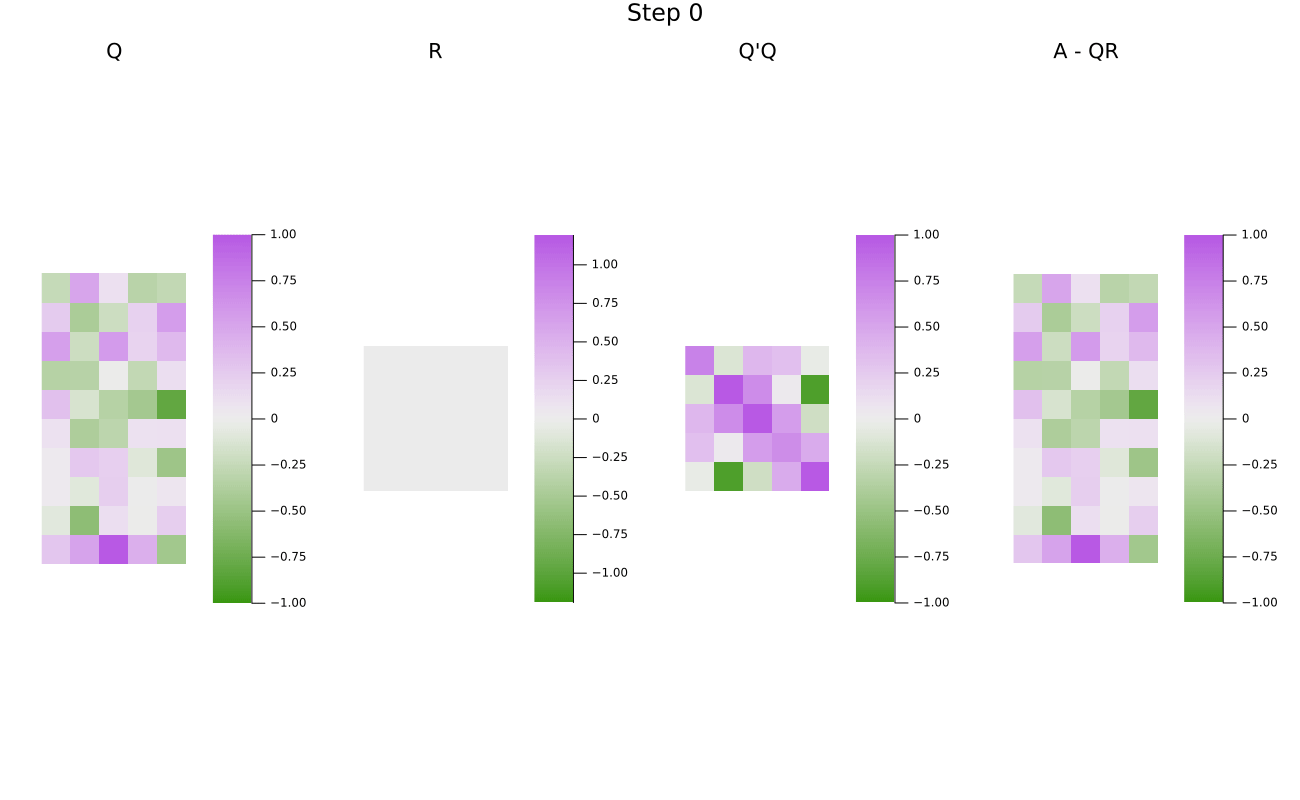

In [18]:
m = 10; n = 5;
A = randn(m, n)
A /= maximum(abs.(A))
Q̂ = copy(A)
R̂ = zeros(n, n)
r_scale = maximum(abs.(qr(A).R))
anim = Animation()
function step_plot(A,Q̂,R̂,j)
    Q_plot = imshow(Q̂,(-1,1))
    plot!(Q_plot,title="Q")
    ortho_plot = imshow(Q̂' * Q̂,(-1,1))
    plot!(ortho_plot,title="Q'Q")
    recon_plot = imshow(A - Q̂ * R̂,(-1,1))
    plot!(recon_plot,title="A - QR")
    R_plot = imshow(R̂,(-r_scale,r_scale))
    plot!(R_plot,title="R")
    return plot(Q_plot, R_plot, ortho_plot, recon_plot, layout=(1,4), size=(1300,800), plot_title="Step $j")
end
frame(anim,step_plot(A,Q̂,R̂,0))
for j in 1:n
    # Compute coefficients of aⱼ in Q̂[:,1:j-1] basis
    R̂[1:j-1,j] = Q̂[:,1:j-1]' * Q̂[:,j]
    # Project Q̂[:,1:j-1] components out of Q̂[:,j]
    Q̂[:,j] -= Q̂[:,1:j-1] * R̂[1:j-1,j]
    # Normalize
    R̂[j,j] = norm(Q̂[:,j])
    Q̂[:,j] /= R̂[j,j]
    frame(anim,step_plot(A,Q̂,R̂,j))
end
frame(anim,step_plot(A,Q̂,R̂,n))
gif(anim,fps=0.5)

### Each step of CGS is a matrix transformation applied to $\hat{Q}$

```julia
        # Project Q̂[:,1:j-1] components out of Q̂[:,j]
        Q̂[:,j] -= Q̂[:,1:j-1] * R̂[1:j-1,j]
```

"Subtract from column $j$: $r_{1,j} \cdot$ column 1 and $r_{2,j} \cdot$ column 2 and ..."

```julia
        # Normalize
        Q̂[:,j] /= R̂[j,j]
```

"Scale column $j$ by $\|r_{j,j}\|^{-1}$"

(Remember warmup for lecture 2: each of these transformations is a matrix applied on the _right_)

### Step $j$: multiply $\hat{Q}$ by an upper-triangular matrix

$$
\begin{bmatrix}
    & & & & & & \\
    & & & & & & \\
    & & & & & & \\
    & & & & & & \\
    & & & \hat{Q} & & & \\
    & & & & & & \\
    & & & & & & \\
    & & & & & & \\
    & & & & & & \\
\end{bmatrix}
\gets
\begin{bmatrix}
    & & & & & & \\
    & & & & & & \\
    & & & & & & \\
    & & & & & & \\
    & & & \hat{Q} & & & \\
    & & & & & & \\
    & & & & & & \\
    & & & & & & \\
    & & & & & & \\
\end{bmatrix}
\underbrace{
\begin{bmatrix}
   1 & & & -r_{1,j} / r_{jj} & & & \\
    & \ddots & & \vdots & & & \\
    & & 1 & -r_{j-1,j} / r_{jj} & & & \\
    & & & 1 / r_{jj} & & & \\
    & & & & 1 & & \\
    & & & & & \ddots & \\
    & & & & & & 1
\end{bmatrix}
}_{Z_j}
$$

$Z_j$ is an upper-triangular matrix one nonzero column in column $j$.

### CGS Constructs $\hat{Q}$ from $A$ by Triangular Orthogonalization
$$
\begin{bmatrix}
 & & \\
 & & \\
 & A & \\
 & & \\
 & & \\
\end{bmatrix}
\underbrace{
\begin{bmatrix}
& & \\
& Z_1 & \\
& & \\
\end{bmatrix}
\begin{bmatrix}
& & \\
& Z_2 & \\
& & \\
\end{bmatrix}
\dots
\begin{bmatrix}
& & \\
& Z_n & \\
& & \\
\end{bmatrix}
}_{\hat{R}^{-1}}
=
\begin{bmatrix}
 & & \\
 & & \\
 & \hat{Q} & \\
 & & \\
 & & \\
\end{bmatrix}
$$

The product of the $Z_j$'s is $\hat{R}^{-1}$.

### Classical Gram-Schmidt meets its adversary: the Kahan matrix

$$
\begin{bmatrix}
& & & & \\
& & & & \\
& & M_\theta & & \\
& & & & \\
& & & & \\
\end{bmatrix}
=
\begin{bmatrix}
1 & & & & \\
& s & & & \\
& & \ddots & & \\
& & & s^{n-2} & \\
& & & & s^{n-1} \\
\end{bmatrix}
\begin{bmatrix}
1 & -c & -c & \dots & -c \\
& 1 & -c & & -c \\
& & \ddots & \ddots & \vdots \\
& & & 1 & -c\\
& & & & 1 \\
\end{bmatrix}
$$


In [19]:
function kahan(m, θ)
    s = sin(θ)
    c = cos(θ)
    S = Diagonal(s .^ collect(0:m-1))
    K = UnitUpperTriangular(-c * ones(m,m))
    return S * K
end

kahan (generic function with 1 method)

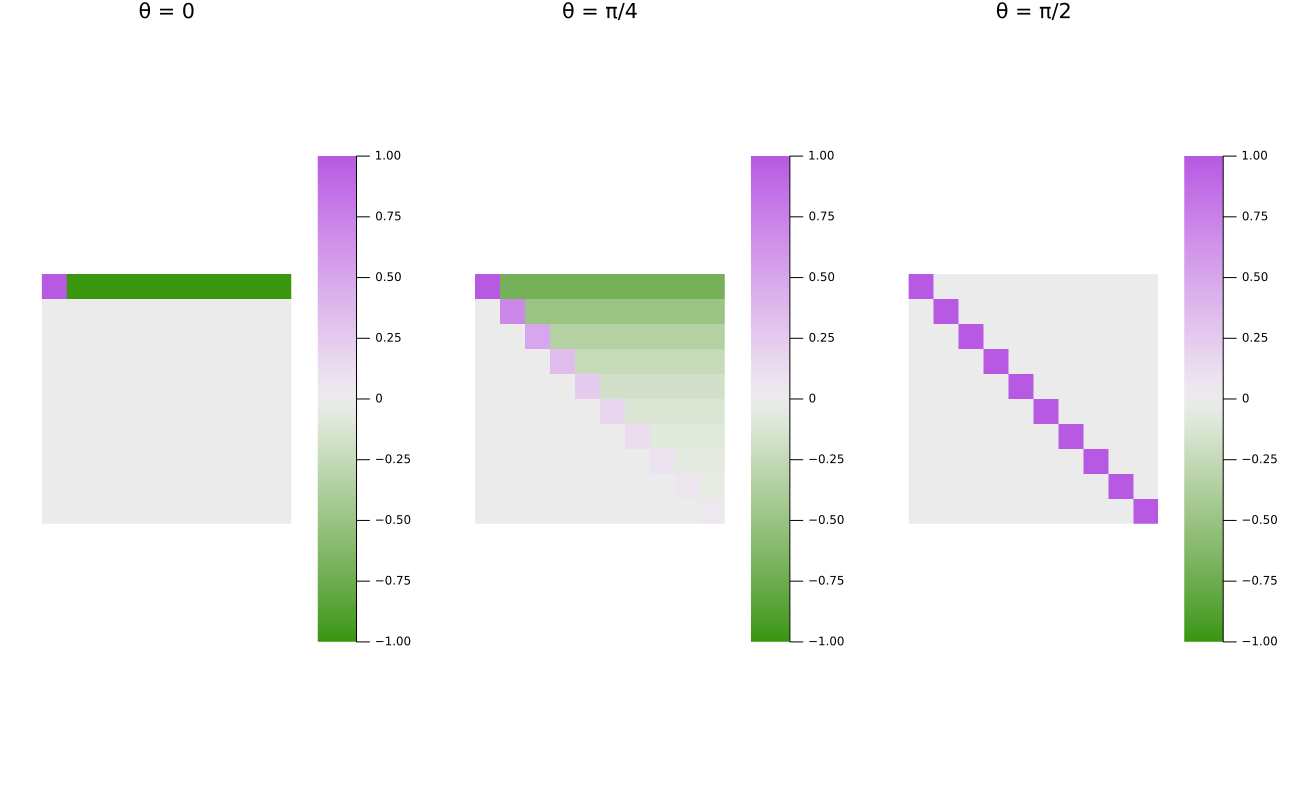

In [20]:
p0 = imshow(kahan(10,eps())); plot!(p0, title="θ = 0")
p4 = imshow(kahan(10,π/4)); plot!(p4, title="θ = π/4")
p2 = imshow(kahan(10,π/2)); plot!(p2, title="θ = π/2")
draw(plot(p0, p4, p2, layout=(1,3), size=(1300,800)))

If $0 < \theta < \pi/2$, each column has its largest component in its first entry; the entries get smaller geometrically.

### CGS on a Kahan matrix vs. CGS on a perturbed Kahan matrix

In [21]:
m = 10; θ = π/20
M = kahan(m, θ)
Q, R = qr_classical_gram_schmidt(M)
qr_test(M, Q, R)

Reconstruction error || A - Q R ||_F = 0.0
Orthonormality error || I - Q'Q ||_F = 0.0
Upper-triangularity error || R - triu(R) ||_F = 0.0


true

In [22]:
ϕ = eps(Float64)
M_p = copy(M[:,:])
rot = [cos(ϕ) sin(ϕ); -sin(ϕ) cos(ϕ)]
M_p[1:2,:] = rot * M[1:2,:]
Q_p, R_p = qr_classical_gram_schmidt(M_p)
qr_test(M_p, Q_p, R_p)

Reconstruction error || A - Q R ||_F = 0.0
Orthonormality error || I - Q'Q ||_F = 1.084717103369114
Upper-triangularity error || R - triu(R) ||_F = 0.0


false

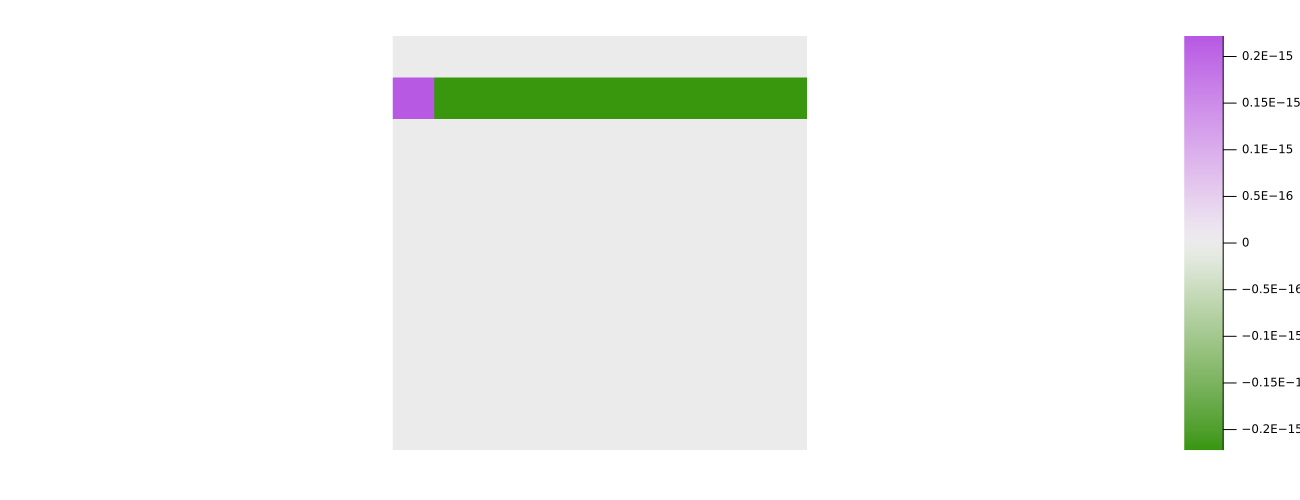

In [23]:
D = M - M_p; dscale = maximum(abs.(D)); p = imshow(D, (-dscale, dscale)); draw(plot!(p, size=(1300, 500)))

┌ Info: Saved animation to 
│   fn = /home/tisaac/srv/rep/22-course-cse6643/mybinder/tmp.gif
└ @ Plots /home/tisaac/.julia/packages/Plots/Xv2qA/src/animation.jl:114


Plots.AnimatedGif("/home/tisaac/srv/rep/22-course-cse6643/mybinder/tmp.gif")
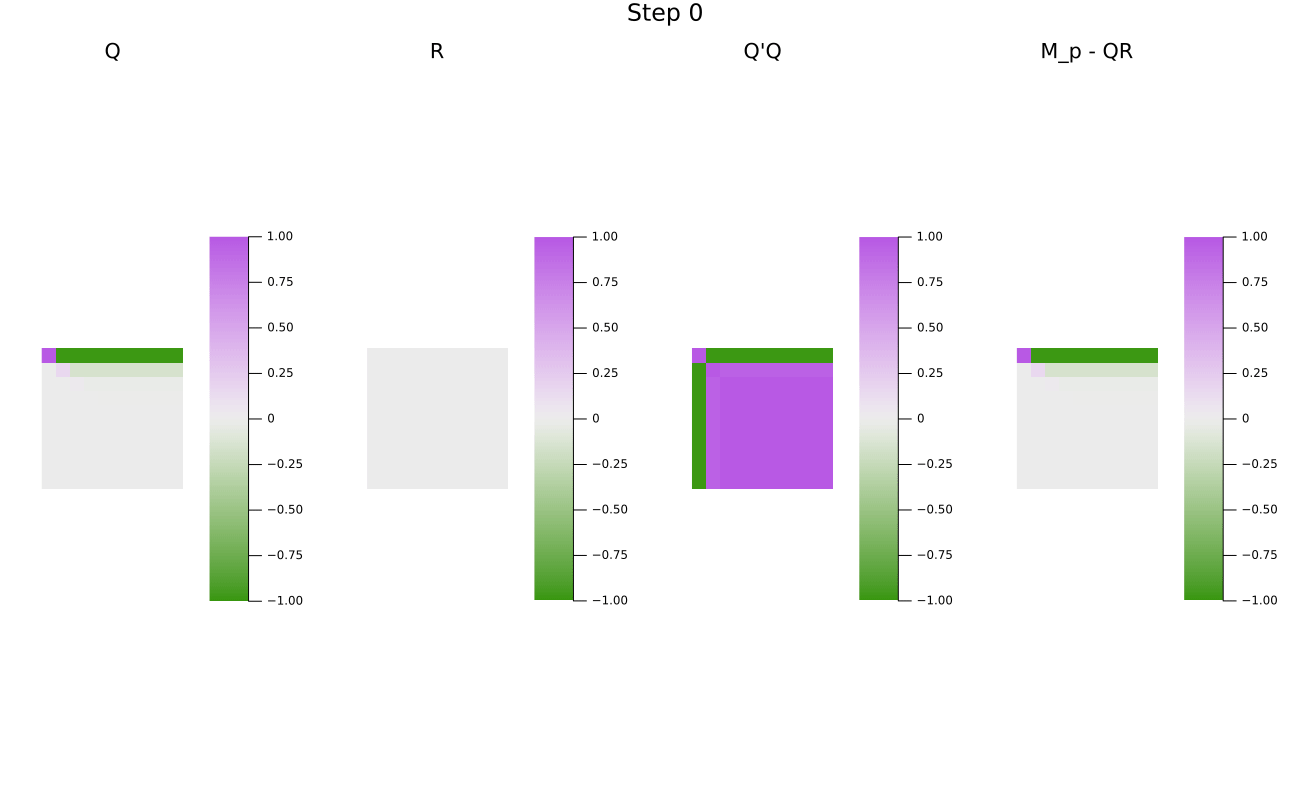

In [24]:
m = 10; n = 10;
M = kahan(m, θ)
M_p = copy(M[:,:])
rot = [cos(ϕ) sin(ϕ); -sin(ϕ) cos(ϕ)]
M_p[1:2,:] = rot * M[1:2,:]
Q̂ = copy(M_p)
R̂ = zeros(n, n)
r_scale = maximum(abs.(qr(M_p).R))
anim = Animation()
function step_plot(A,Q̂,R̂,j)
    Q_plot = imshow(Q̂,(-1,1))
    plot!(Q_plot,title="Q")
    ortho_plot = imshow(Q̂' * Q̂)
    plot!(ortho_plot,title="Q'Q")
    recon_plot = imshow(M_p - Q̂ * R̂,(-1,1))
    plot!(recon_plot,title="M_p - QR")
    R_plot = imshow(R̂,(-r_scale,r_scale))
    plot!(R_plot,title="R")
    return plot(Q_plot, R_plot, ortho_plot, recon_plot, layout=(1,4), size=(1300,800), plot_title="Step $j")
end
frame(anim,step_plot(M_p,Q̂,R̂,0))
for j in 1:n
    # Compute coefficients of aⱼ in Q̂[:,1:j-1] basis
    R̂[1:j-1,j] = Q̂[:,1:j-1]' * Q̂[:,j]
    # Project Q̂[:,1:j-1] components out of Q̂[:,j]
    Q̂[:,j] -= Q̂[:,1:j-1] * R̂[1:j-1,j]
    # Normalize
    R̂[j,j] = norm(Q̂[:,j])
    Q̂[:,j] /= R̂[j,j]
    frame(anim,step_plot(M_p,Q̂,R̂,j))
end
frame(anim,step_plot(M_p,Q̂,R̂,n))
gif(anim,fps=0.5)

### What happens in the last column of the perturbed Kahan matrix?

$$ \tilde{q}_m \gets (I - P_{1:m-1}) a_m = a_m - q_1 q_1^* a_m - q_2 q_2^* a_m - \dots $$

- In exact arithmetic, $\|\tilde{q}_m\|_2$ is very small: $\sin(\theta)^{m-1} \approx 6 \cdot 10^{-8}$ 

- Consider just the first projection:

$$s_1 = a_m - q_1 (q_1^* a_m)$$
  
- In the presence of rounding error, a perturbed vector $\hat s_1 = s_1 + \delta_1$ is computed with error $\delta_1$

- Later on in the class we will see that $\|\delta_1\|$ is proportional to $\epsilon\|a_m\|$, where $\epsilon \approx 10^{-16}$

### The accumulation of roundoff errors has swamped the result

- There were similar small but growing errors in the previous $q_j$s.  Instead of calculating $\tilde{q}_m$, we have calculated

$$\tilde{q}_m + \delta_1 + \delta_2 + \dots + \delta_{m-1}.$$

- The errors are as big as the desired quantity, 

$$\|\tilde{q}_m\| \approx \|\delta_1 + \delta_2 + \dots + \delta_{m-1}\|.$$

- When we then normalize, $q_m \gets \tilde{q}_m / \|\tilde{q}_m\|$, the errors are magnified from $\sim 10^{-8}$ to $\sim 10^{0}$: catastrophe!

In [25]:
ortho_errs_cgs = Float64[]
ortho_errs_qr = Float64[]
recon_errs_cgs = Float64[]
recon_errs_qr = Float64[]
range = π ./ (2:.1:20)
for θ in range
    M = kahan(10, θ)
    ϕ = eps(Float64)
    M_p = copy(M[:,:])
    rot = [cos(ϕ) sin(ϕ); -sin(ϕ) cos(ϕ)]
    M_p[1:2,:] = rot * M[1:2,:]
    Q_cgs, R_cgs = qr_classical_gram_schmidt(M_p)
    Q, R = qr(M_p)
    push!(ortho_errs_cgs, orthonormality_error(Q_cgs))
    push!(ortho_errs_qr, orthonormality_error(Q[:,:]))
    push!(recon_errs_cgs, reconstruction_error(M_p, Q_cgs, R_cgs))
    push!(recon_errs_qr, reconstruction_error(M_p, Q, R))
end
ymin=Inf
ymax=0.
for series in [ortho_errs_cgs, ortho_errs_qr, recon_errs_cgs, recon_errs_qr]
    series[:] = max.(series[:], 0.001*eps())
    ymin = min(ymin, minimum(series))
    ymax = max(ymax, maximum(series))
end
ymin *= 0.5
ymax *= 2.0
p1 = plot( range .^-1, [ortho_errs_cgs recon_errs_cgs]
    , yscale=:log10
    , label=["orthonormality error" "reconstruction error"]
    , xlabel="Kahan matrix θ⁻¹"
    , title="Classical Gram-Schmidt"
    , size=(1300,800)
    , ylim=(ymin,ymax)
)
p2 = plot( range .^-1, [ortho_errs_qr recon_errs_qr]
    , yscale=:log10
    , label=["orthonormality error" "reconstruction error"]
    , xlabel="Kahan matrix θ⁻¹"
    , title="julia QR"
    , size=(1300,800)
    , ylim=(ymin,ymax)
)
daw(plot(p1,p2,layout=(1,2)))

LoadError: UndefVarError: daw not defined

## Modified Gram-Schmidt

### Consider projecting out two components of a vector

Let $\hat{Q} = [q_1 | q_2]$, and project out the $\hat{Q}$ component of vector $v$,

$$w \gets (I - \hat{Q} \hat{Q}^*)v$$

In exact arithmetic, these are equivalent:

$$w \gets (I - \hat{Q}\hat{Q}^*) v$$

AKA:

$$
\begin{aligned}
w^{(0)} &\gets v - q_1 (q_1^* v) \\
w &\gets w^{(0)} - q_2 (q_2^* v)
\end{aligned}
$$

$$ w \gets (I - q_2 q_2^*) (I - q_1 q_1^*) v $$

AKA:

$$
\begin{aligned}
w^{(0)} &\gets v - q_1 (q_1^* v)
\\
w &\gets w^{(0)} - q_2 (q_2^* w^{(0)})
\end{aligned}
$$

### Floating point rounding error scales like the inputs

$$
\begin{aligned}
w^{(0)} &\gets \underbrace{v - q_1 (q_1^* v)}_{\delta_1 \sim \epsilon \|v\|} \\
w &\gets \underbrace{w^{(0)} - q_2 (q_2^* v)}_{\delta_2 \sim \epsilon \max\{\|w^{(0)}\|,\|v\|\}}
\end{aligned}
$$

$$
\begin{aligned}
w^{(0)} &\gets \underbrace{v - q_1 (q_1^* v)}_{\delta_1 \sim \epsilon \|v\|} \\
w &\gets \underbrace{w^{(0)} - q_2 (q_2^* w^{(0)})}_{\delta_2 \sim \epsilon \|w^{(0)}\|}
\end{aligned}
$$

- The first approach (calculating every projection coefficient $(q_i^*v)$ with the original vector) accumulates a rounding error $\sim \epsilon \|v\|$ _for each projection_,
$\sim \epsilon(\|v\| + \|v\| + \|v\| + \dots)$.

- The second approach (calculating $q_j$'s projection coefficient on the result of the previous projections) accumulates rounding errors $\sim \epsilon (\|v\| + \|(I-P_1)v\| + \|(I-P_{1:2})v\| + \dots)$.

- Orthogonal projection can only make a vector smaller, $\|v\| \geq \|(I - P_1) v\| \geq \|(I - P_{1:2})v \| \geq \dots$.

### Exercise: Modified Gram-Schmidt (forward looking)

At step $i$:

1. Normalize:

$$
\begin{aligned}
r_{i,i} &\gets \|\tilde{q}_i\| \\
q_j &\gets \tilde{q}_i / r_{ii}
\end{aligned}
$$

2. Project $q_i$ out of all subsequent vectors $j > i$

$$
\begin{aligned}
r_{i,j} &\gets q_i^* \tilde{q}_j \\
\tilde{q}_j &\gets \tilde{q}_j - r_{i,j} q_i 
\end{aligned}
$$

In [26]:
function cg_modified_gram_schmidt(A)
    n = size(A)[2]
    Q = copy(A)
    R = zeros(eltype(A), n, n)
    # ...
    return Q, R
end
m = 10; n = 5;
A = randn(m,n)
Q, R = cg_modified_gram_schmidt(A)
qr_test(A, Q, R)

Reconstruction error || A - Q R ||_F = 6.46872892925176
Orthonormality error || I - Q'Q ||_F = 20.82690045709607
Upper-triangularity error || R - triu(R) ||_F = 0.0


false

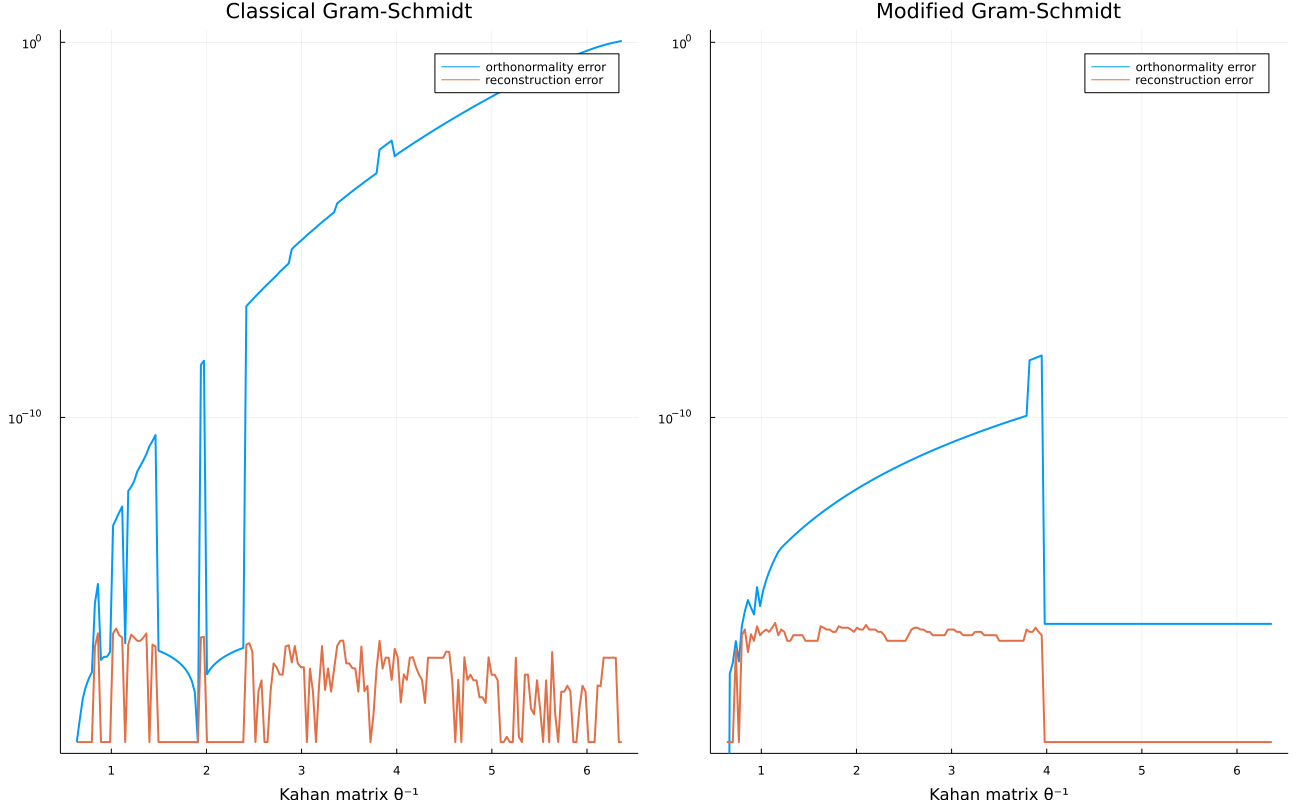

In [27]:
function mgs(A)
    m, n = size(A)
    Q = copy(A)
    R = zeros(eltype(A), n, n)
    for i in 1:n
        R[i,i] = norm(Q[:,i])
        Q[:,i] /= R[i,i]
        R[i,i+1:end] = Q[:,i]' * Q[:,i+1:end]
        Q[:,i+1:end] -= Q[:,[i]] * R[[i],i+1:end]
    end
    return Q, R
end
ortho_errs_mgs = Float64[]
recon_errs_mgs = Float64[]
for θ in range
    M = kahan(10, θ)
    ϕ = eps(Float64)
    M_p = copy(M[:,:])
    rot = [cos(ϕ) sin(ϕ); -sin(ϕ) cos(ϕ)]
    M_p[1:2,:] = rot * M[1:2,:]
    Q_mgs, R_mgs = mgs(M_p)
    push!(ortho_errs_mgs, orthonormality_error(Q_mgs))
    push!(recon_errs_mgs, reconstruction_error(M_p, Q_mgs, R_mgs))
end
ymin=Inf
ymax=0.
for series in [ortho_errs_cgs, ortho_errs_qr, recon_errs_mgs, recon_errs_mgs]
    series[:] = max.(series[:], 0.001*eps())
    ymin = min(ymin, minimum(series))
    ymax = max(ymax, maximum(series))
end
ymin *= 0.5
ymax *= 2.0
p1 = plot( range .^-1, [ortho_errs_cgs recon_errs_cgs]
    , yscale=:log10
    , label=["orthonormality error" "reconstruction error"]
    , xlabel="Kahan matrix θ⁻¹"
    , title="Classical Gram-Schmidt"
    , size=(1300,800)
    , ylim=(ymin,ymax)
)
p2 = plot( range .^-1, [ortho_errs_mgs recon_errs_mgs]
    , yscale=:log10
    , label=["orthonormality error" "reconstruction error"]
    , xlabel="Kahan matrix θ⁻¹"
    , title="Modified Gram-Schmidt"
    , size=(1300,800)
    , ylim=(ymin,ymax)
)
draw(plot(p1,p2,layout=(1,2)))

### Modified Gram-Schmidt in Action (go back and compare)

┌ Info: Saved animation to 
│   fn = /home/tisaac/srv/rep/22-course-cse6643/mybinder/tmp.gif
└ @ Plots /home/tisaac/.julia/packages/Plots/Xv2qA/src/animation.jl:114


Plots.AnimatedGif("/home/tisaac/srv/rep/22-course-cse6643/mybinder/tmp.gif")
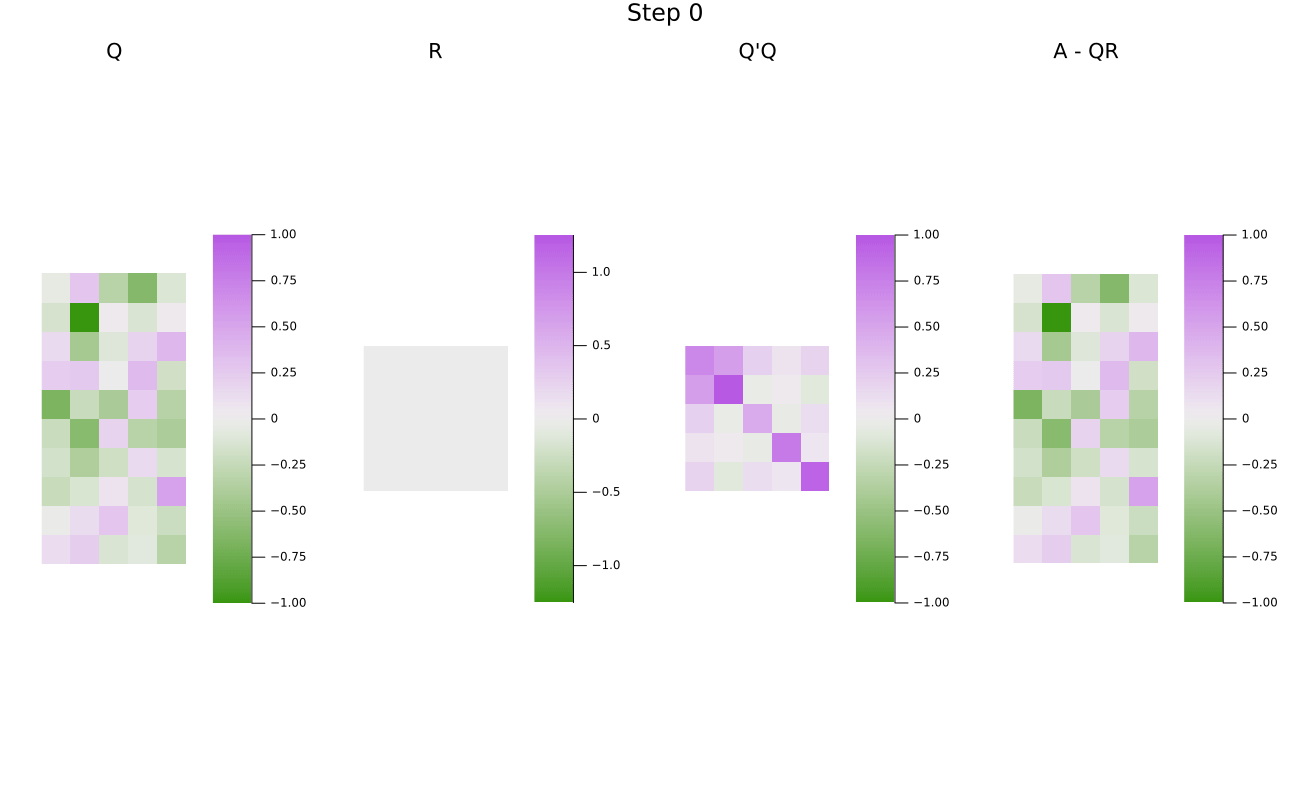

In [28]:
m = 10; n = 5;
A = randn(m, n)
A /= maximum(abs.(A))
Q̂ = copy(A)
R̂ = zeros(n, n)
r_scale = maximum(abs.(qr(A).R))
anim = Animation()
function step_plot(A,Q̂,R̂,j)
    Q_plot = imshow(Q̂,(-1,1))
    plot!(Q_plot,title="Q")
    ortho_plot = imshow(Q̂' * Q̂,(-1,1))
    plot!(ortho_plot,title="Q'Q")
    recon_plot = imshow(A - Q̂ * R̂,(-1,1))
    plot!(recon_plot,title="A - QR")
    R_plot = imshow(R̂,(-r_scale,r_scale))
    plot!(R_plot,title="R")
    return plot(Q_plot, R_plot, ortho_plot, recon_plot, layout=(1,4), size=(1300,800), plot_title="Step $j")
end
frame(anim,step_plot(A,Q̂,R̂,0))
for i in 1:n
    R̂[i,i] = norm(Q̂[:,i])
    Q̂[:,i] /= R̂[i,i]
    R̂[i,i+1:end] = Q̂[:,i]' * Q̂[:,i+1:end]
    Q̂[:,i+1:end] -= Q̂[:,[i]] * R̂[[i],i+1:end]
    frame(anim,step_plot(A,Q̂,R̂,i))
end
frame(anim,step_plot(A,Q̂,R̂,n))
gif(anim,fps=0.5)

### Modified Gram-Schmidt also constructs $\hat{Q}$ by Triangular Orthogonalization

At step $i$:

$$
\begin{bmatrix}
    & & & & & & \\
    & & & & & & \\
    & & & & & & \\
    & & & & & & \\
    & & & \hat{Q} & & & \\
    & & & & & & \\
    & & & & & & \\
    & & & & & & \\
    & & & & & & \\
\end{bmatrix}
\gets
\begin{bmatrix}
    & & & & & & \\
    & & & & & & \\
    & & & & & & \\
    & & & & & & \\
    & & & \hat{Q} & & & \\
    & & & & & & \\
    & & & & & & \\
    & & & & & & \\
    & & & & & & \\
\end{bmatrix}
\underbrace{
\begin{bmatrix}
   1 & & & & & & \\
    & \ddots & & & & & \\
    & & 1 & & & & \\
    & & & \frac{1}{r_{ii}} & \frac{-r_{i,i+1}}{r_{ii}} & \dots & \frac{-r_{i,n}}{r_{ii}} \\
    & & & & 1 & & \\
    & & & & & \ddots & \\
    & & & & & & 1
\end{bmatrix}
}_{Z_i}
$$

$Z_i$ is an upper-triangular matrix with one nonzero row in row $i$.


### Notes on HW2, problem 4

You have seen CGS and MGS in this lecture.  It will probably take you more time to construct the plot.
The syntax is intentionally similar to MATLAB / matplotlib, but for reference, go to <https://docs.juliaplots.org>.

## Gram-Schmidt Complexity

### Matrx-Matrix Product Complexity

Given matrices $A\in \mathbb{C}^{M \times K}$, $B \in \mathbb{C}^{K \times N}$, and $C \in \mathbb{C}^{M \times N}$, the work $W$ measured in _floating point operations_ ("flops") of computing $C \gets C - AB$ using the standard approach is

$$W(C - A \cdot B) = 2 M N K,$$

which is clear from looking at the algorithm written component-wise:

```julia
for i in 1:M                          # M times ...
    for j in 1:N                      # N times ...
        for p in 1:K                  # K times ...
            C[i,j] -= A[i,p] * B[p,j] # 2 flops per inner loop
        end
    end
end
            
```

if we just compute $C \gets A B$, there is one subtraction less per entry of $C$, so

$$W(A \cdot B) = 2 M N K - M N.$$

### Projection Orthogonalization Complexity

If $\hat{Q} \in \mathbb{C}^{m \times j}$ and $a \in \mathbb{C}^m$, what is the complexity of

$$\tilde{q} \gets a - \hat{Q}(\hat{Q}^*a)?$$

Rephrase as:

$$
\begin{aligned}
r &\gets \hat{Q}^* a \\
\tilde{q} &\gets a - \hat{Q}r
\end{aligned}
$$

- First line is like $C \gets A B$ with $M = j$, $N = 1$, and $K = m$, so $W = 2 M N K - M N = 2jm - j$.

- Second line is like $C \gets C - AB$ with $M = m$, $N = 1$ and $K = j$, so $W = 2 M N K = 2jm$

- Total,

$$W((I - \hat{Q}\hat{Q}^*) a) = 4 jm - j.$$

In [29]:
function qr_classical_gram_schmidt(A)
    m, n = size(A)
    Q̂ = copy(A)
    R̂ = zeros(eltype(A), n, n)
    for j in 1:n
        # Project
        R̂[1:j-1,j] = Q̂[:,1:j-1]' * Q̂[:,j] # 2 m j - j
        Q̂[:,j] -= Q̂[:,1:j-1] * R̂[1:j-1,j] # 2 m j
        # Normalize
        R̂[j,j] = norm(Q̂[:,j])             # 2 m
        Q̂[:,j] /= R̂[j,j]                  # 1
    end
    return Q̂, R̂
end

qr_classical_gram_schmidt (generic function with 1 method)

- Total work in iteration $j$:

$$4mj - j + 2 m + 1$$

- Total (sum for $j = 1, \dots, n$):

$$
W(CGS) = \sum_{j=1}^n 4mj - j + 2m + 1 = \left\{(4m - 1) \sum_{j=1}^n j\right\} + \left\{(2m + 1) \sum_{j=1}^n 1\right\}.
$$

$$W(CGS) = (4m-1)\frac{1}{2}n(n+1) + (2m + 1)n = 2 m n^2 + \underbrace{\dots}_{\text{(lower order terms)}}.$$

### Summarize using just the leading term

$$W(CGS) \sim 2 mn^2,$$

which means

$$ \lim_{\min\{m,n\} \to \infty} \frac{W(CGS)}{2 m n^2} = 1. $$

### Exercise

Convince yourself that $W(MGS) = W(CGS) \sim 2 m n^2.$

### Caveats on the meaning of work $W$

- On a serial computer, runtime $T$ should scale like $W$ for large enough inputs.
- $W$ does not count moving data to/from the processor, which is more expensive than arithmetic.
- Implementation-dependent leading constants are going to be very important, so its possible to have two algorithms with $W_1 < W_2$ but $T_2 < T_1$.
- All computers use parallelism for numerical linear algebra now.  $W$ says nothing about how _concurrent_ (parallelizable) CGS and WGS are, so $W$ alone is not enough to understand the performance of an algorithm.